In [1]:
import pandas as pd
import numpy as np 
import csvw

import scipy.stats as scs
import statsmodels.api as sm
import statsmodels.formula.api as sms
import scipy.stats as stats

from haversine import haversine
from math import sqrt

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier 
from sklearn.naive_bayes import BernoulliNB, CategoricalNB, GaussianNB, MultinomialNB
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix, accuracy_score, precision_recall_curve, f1_score, precision_score, recall_score
from sklearn.base import BaseEstimator
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.pipeline import Pipeline

import matplotlib.pyplot as plt
import seaborn as sns
pd.options.display.float_format = '{:.2f}'.format

In [2]:
df = pd.read_csv(r'data/ChicagoCrashes.csv')

In [3]:
yes_no_converter = lambda x: 1 if x>=1 else 0

In [4]:
df.describe()

,Unnamed: 0,CRASH_DATE_x,OCCUPANT_CNT,POSTED_SPEED_LIMIT,BEAT_OF_OCCURRENCE,NUM_UNITS,INJURIES_TOTAL,INJURIES_FATAL,INJURIES_INCAPACITATING,INJURIES_NON_INCAPACITATING,INJURIES_REPORTED_NOT_EVIDENT,INJURIES_NO_INDICATION,INJURIES_UNKNOWN,CRASH_HOUR,CRASH_DAY_OF_WEEK,CRASH_MONTH,LATITUDE,LONGITUDE
count,567454.00,567454.00,567454.00,567454.00,567454.00,567454.00,567454.00,567454.00,567454.00,567454.00,567454.00,567454.00,567454.00,567454.00,567454.00,567454.00,567454.00,567454.00
mean,990211.98,2018.06,1.41,28.89,1233.98,2.16,0.25,0.00,0.02,0.13,0.09,2.74,0.00,13.37,4.15,6.72,41.86,-87.68
std,594777.08,1.28,1.41,5.92,699.58,0.56,0.77,0.03,0.19,0.57,0.44,2.01,0.00,5.13,1.96,3.39,0.08,0.06
min,1.00,2015.00,0.00,0.00,111.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,41.64,-87.93
25%,475494.25,2017.00,1.00,30.00,725.00,2.00,0.00,0.00,0.00,0.00,0.00,2.00,0.00,10.00,2.00,4.00,41.79,-87.72
50%,965871.50,2018.00,1.00,30.00,1212.00,2.00,0.00,0.00,0.00,0.00,0.00,2.00,0.00,14.00,4.00,7.00,41.88,-87.67
75%,1494691.25,2019.00,2.00,30.00,1821.00,2.00,0.00,0.00,0.00,0.00,0.00,3.00,0.00,17.00,6.00,10.00,41.92,-87.63
max,2115933.00,2020.00,60.00,99.00,2535.00,15.00,21.00,3.00,6.00,21.00,15.00,61.00,0.00,23.00,7.00,12.00,42.02,-87.52


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 567454 entries, 0 to 567453
Data columns (total 49 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   Unnamed: 0                     567454 non-null  int64  
 1   CRASH_DATE_x                   567454 non-null  int64  
 2   UNIT_TYPE                      567454 non-null  object 
 3   MAKE                           567454 non-null  object 
 4   MODEL                          567454 non-null  object 
 5   VEHICLE_DEFECT                 567454 non-null  object 
 6   VEHICLE_TYPE                   567454 non-null  object 
 7   VEHICLE_USE                    567454 non-null  object 
 8   MANEUVER                       567454 non-null  object 
 9   OCCUPANT_CNT                   567454 non-null  float64
 10  CRASH_DATE_y                   567454 non-null  object 
 11  POSTED_SPEED_LIMIT             567454 non-null  int64  
 12  TRAFFIC_CONTROL_DEVICE        

In [6]:
# target data, what we are trying to predict, should it be death ?
print(df['INJURIES_FATAL'].sum()) # 685 deaths out of this 1.1 million line dataset - how can you predict them?

331.0


In [7]:
def transform_df(df): # this will create a binary encoding for fatalities in an accident,
    # 1 for a fatality was present
    # and 0 for no fatality present
    df['INJURIES_FATAL'] = df['INJURIES_FATAL'].apply(yes_no_converter)
    # df['y'] = df['y'].apply(yes_no_converter)
    return df

df = transform_df(df)

In [8]:
print(df['MOST_SEVERE_INJURY'].unique()) # what can we learn by attempting to classify the most severe injury?

['NO INDICATION OF INJURY' 'NONINCAPACITATING INJURY'
 'REPORTED, NOT EVIDENT' 'INCAPACITATING INJURY' 'FATAL']


In [9]:
# KNN is not good with large or wide datasets, lets choose a different method. 

In [10]:
df.head()

,Unnamed: 0,CRASH_DATE_x,UNIT_TYPE,MAKE,MODEL,VEHICLE_DEFECT,VEHICLE_TYPE,VEHICLE_USE,MANEUVER,OCCUPANT_CNT,...,LATITUDE,LONGITUDE,PERSON_ID,PERSON_TYPE,CRASH_DATE,SEX,SAFETY_EQUIPMENT,AIRBAG_DEPLOYED,EJECTION,INJURY_CLASSIFICATION
0,577317,2016,DRIVER,"TOYOTA MOTOR COMPANY, LTD.",CAMRY,NONE,PASSENGER,PERSONAL,TURNING RIGHT,1.00,...,41.69,-87.54,O35015,DRIVER,03/18/2016 02:50:00 PM,F,SAFETY BELT USED,DID NOT DEPLOY,NONE,NO INDICATION OF INJURY
1,1612677,2019,DRIVER,BUICK,ENCLAVE,NONE,PASSENGER,PERSONAL,STRAIGHT AHEAD,1.00,...,41.74,-87.60,O804356,DRIVER,12/17/2019 04:04:00 PM,M,SAFETY BELT USED,NOT APPLICABLE,NONE,NO INDICATION OF INJURY
2,547332,2018,DRIVER,CHEVROLET,MALIBU (CHEVELLE),NONE,PASSENGER,PERSONAL,AVOIDING VEHICLES/OBJECTS,1.00,...,41.80,-87.58,O337302,DRIVER,03/05/2018 12:35:00 PM,F,SAFETY BELT USED,DID NOT DEPLOY,NONE,NO INDICATION OF INJURY
3,756129,2018,DRIVER,HYUNDAI,Accent,NONE,PASSENGER,PERSONAL,STRAIGHT AHEAD,1.00,...,41.97,-87.79,O427371,DRIVER,07/07/2018 12:50:00 PM,F,SAFETY BELT USED,DID NOT DEPLOY,NONE,NO INDICATION OF INJURY
4,95047,2017,DRIVER,CHEVROLET,MONTE CARLO,NONE,PASSENGER,PERSONAL,BACKING,1.00,...,41.77,-87.66,O141732,DRIVER,04/01/2017 11:35:00 AM,M,SAFETY BELT USED,DID NOT DEPLOY,NONE,NO INDICATION OF INJURY


In [11]:
df = df.drop(columns=['Unnamed: 0', 'MAKE', 'MODEL', 'LATITUDE', 'LONGITUDE', 'CRASH_DATE', 'CRASH_DATE_y', 'ALIGNMENT', 'BEAT_OF_OCCURRENCE', 'MOST_SEVERE_INJURY', 'INJURIES_TOTAL', 'INJURIES_INCAPACITATING', 'INJURIES_NON_INCAPACITATING', 'INJURIES_REPORTED_NOT_EVIDENT', 'INJURIES_NO_INDICATION', 'INJURIES_UNKNOWN', 'PERSON_ID', 'CRASH_DATE', 'INJURY_CLASSIFICATION'])

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 567454 entries, 0 to 567453
Data columns (total 31 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   CRASH_DATE_x             567454 non-null  int64  
 1   UNIT_TYPE                567454 non-null  object 
 2   VEHICLE_DEFECT           567454 non-null  object 
 3   VEHICLE_TYPE             567454 non-null  object 
 4   VEHICLE_USE              567454 non-null  object 
 5   MANEUVER                 567454 non-null  object 
 6   OCCUPANT_CNT             567454 non-null  float64
 7   POSTED_SPEED_LIMIT       567454 non-null  int64  
 8   TRAFFIC_CONTROL_DEVICE   567454 non-null  object 
 9   DEVICE_CONDITION         567454 non-null  object 
 10  WEATHER_CONDITION        567454 non-null  object 
 11  LIGHTING_CONDITION       567454 non-null  object 
 12  FIRST_CRASH_TYPE         567454 non-null  object 
 13  TRAFFICWAY_TYPE          567454 non-null  object 
 14  ROAD

In [13]:
df_dummies = pd.get_dummies(df)


In [124]:
df['CRASH_DATE_x'].max()

2020

In [14]:
df_train, df_valid = train_test_split(df_dummies, test_size=0.30)

In [15]:
display(df_train.info())
display(df_valid.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 397217 entries, 196452 to 290726
Columns: 319 entries, CRASH_DATE_x to EJECTION_UNKNOWN
dtypes: float64(1), int64(7), uint8(311)
memory usage: 145.1 MB


None

<class 'pandas.core.frame.DataFrame'>
Int64Index: 170237 entries, 31363 to 108389
Columns: 319 entries, CRASH_DATE_x to EJECTION_UNKNOWN
dtypes: float64(1), int64(7), uint8(311)
memory usage: 62.2 MB


None

In [123]:
df_train_X = df_train.drop(columns='INJURIES_FATAL')
df_train_y = df_train['INJURIES_FATAL']

X = df_train_X
y = df_train_y
data_full = df_train.groupby(by='INJURIES_FATAL').sum()
data_full.to_csv('crash_data.csv')

In [17]:
cat_bayes = CategoricalNB()

In [18]:
cat_bayes.fit(X,y)

CategoricalNB()

In [19]:
df_valid_X = df_valid.drop(columns='INJURIES_FATAL')
df_valid_y = df_valid['INJURIES_FATAL']

X_valid = pd.get_dummies(df_valid_X)
y_valid = df_valid_y

In [20]:
X.shape, y.shape, X_valid.shape, y_valid.shape

((397217, 318), (397217,), (170237, 318), (170237,))

In [21]:
train_score1 = cat_bayes.score(X,y)
print(train_score1)

0.9901993117112309


In [22]:
test_score1 = cat_bayes.score(X_valid, y_valid)
print(test_score1)

0.9900902858955456


In [23]:
if(train_score1 > test_score1):
    print('Model is overfit')
else:
    print('Model is not overfit')

Model is overfit


In [24]:
y_valid_pred = cat_bayes.predict(X_valid)

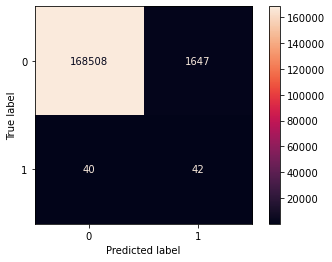

In [25]:
plot_confusion_matrix(cat_bayes, X_valid, y_valid, cmap='rocket', values_format='1')
plt.show()

In [26]:
def score_report(ytrue, ypred):
    print("Accuracy Score: ", accuracy_score(ytrue, ypred))
    print("Precision Score: ", precision_score(ytrue, ypred)) # a little difficult for this to tell us much given the small ratio of fatalities to accidents
    print("Recall Score: ", recall_score(ytrue, ypred)) # recall score is helpful, we can see that we are modeling almost 63% of accidents where there is a fatality     
    print("F1 Score: ", f1_score(ytrue, ypred))
    pass

In [27]:
score_report(y_valid, y_valid_pred)

Accuracy Score:  0.9900902858955456
Precision Score:  0.02486678507992895
Recall Score:  0.5121951219512195
F1 Score:  0.047430830039525695


In [28]:
print('''
      This is the total number of accidents with a fatality 
      divided by the total number of accidents, expressed as 
      a percent: ''',(df['INJURIES_FATAL'].sum()/df['INJURIES_FATAL'].count()*100))
print('''
      This is the total number of accidents with a fatality: ''',df['INJURIES_FATAL'].sum())
print('''
      This is the total number of accidents: ''', df['INJURIES_FATAL'].count())


      This is the total number of accidents with a fatality 
      divided by the total number of accidents, expressed as 
      a percent:  0.0470522720784416

      This is the total number of accidents with a fatality:  267

      This is the total number of accidents:  567454


In [29]:
# based on the above we can see that this model is missing the mark on attempting
# to predict where someone is likely to lose their life, missing on 16/43 actual
# fatalities. it additionally misclassifies 1166 accidents where there was no fatality
# but has indicated a false positive. The false positives are a problem in this model. 

In [30]:
selector = SelectKBest(score_func=chi2, k=15)

In [31]:
sel = selector.fit(X,y)

In [32]:
dfscores = sel.scores_
dfcols = X.columns

featscore = {}
for num in list(range(len(dfcols))):
    featscore[dfcols[num]] = round(dfscores[num], 2)
    
top_18 = {}
for item in sorted(featscore.items(), key=lambda x: x[1], reverse=True)[:18]:
    top_18[item[0]] = item[1]

In [33]:
top_18 # most impactful features indicating a fatality is likely

{'EJECTION_TRAPPED/EXTRICATED': 1713.88,
 'PRIM_CONTRIBUTORY_CAUSE_PHYSICAL CONDITION OF DRIVER': 1156.52,
 'FIRST_CRASH_TYPE_PEDESTRIAN': 560.35,
 'AIRBAG_DEPLOYED_DEPLOYED, COMBINATION': 469.23,
 'EJECTION_TOTALLY EJECTED': 426.88,
 'PRIM_CONTRIBUTORY_CAUSE_EXCEEDING AUTHORIZED SPEED LIMIT': 398.23,
 'CRASH_TYPE_INJURY AND / OR TOW DUE TO CRASH': 374.3,
 'SAFETY_EQUIPMENT_HELMET NOT USED': 239.22,
 'VEHICLE_TYPE_MOTORCYCLE (OVER 150CC)': 168.14,
 'REPORT_TYPE_ON SCENE': 146.24,
 'SEC_CONTRIBUTORY_CAUSE_PHYSICAL CONDITION OF DRIVER': 143.71,
 'CRASH_TYPE_NO INJURY / DRIVE AWAY': 135.81,
 'REPORT_TYPE_NOT ON SCENE (DESK REPORT)': 106.8,
 'NUM_UNITS': 100.46,
 'PRIM_CONTRIBUTORY_CAUSE_DISREGARDING TRAFFIC SIGNALS': 98.52,
 'FIRST_CRASH_TYPE_FIXED OBJECT': 70.11,
 'PRIM_CONTRIBUTORY_CAUSE_OPERATING VEHICLE IN ERRATIC, RECKLESS, CARELESS, NEGLIGENT OR AGGRESSIVE MANNER': 68.34,
 'SEC_CONTRIBUTORY_CAUSE_DISREGARDING TRAFFIC SIGNALS': 68.15}

In [34]:
def getList(dict):
    return dict.keys()

new_features = getList(top_18)

In [71]:
top18_features = list(new_features)
print(top18_features)

['EJECTION_TRAPPED/EXTRICATED', 'PRIM_CONTRIBUTORY_CAUSE_PHYSICAL CONDITION OF DRIVER', 'FIRST_CRASH_TYPE_PEDESTRIAN', 'AIRBAG_DEPLOYED_DEPLOYED, COMBINATION', 'EJECTION_TOTALLY EJECTED', 'PRIM_CONTRIBUTORY_CAUSE_EXCEEDING AUTHORIZED SPEED LIMIT', 'CRASH_TYPE_INJURY AND / OR TOW DUE TO CRASH', 'SAFETY_EQUIPMENT_HELMET NOT USED', 'VEHICLE_TYPE_MOTORCYCLE (OVER 150CC)', 'REPORT_TYPE_ON SCENE', 'SEC_CONTRIBUTORY_CAUSE_PHYSICAL CONDITION OF DRIVER', 'CRASH_TYPE_NO INJURY / DRIVE AWAY', 'REPORT_TYPE_NOT ON SCENE (DESK REPORT)', 'NUM_UNITS', 'PRIM_CONTRIBUTORY_CAUSE_DISREGARDING TRAFFIC SIGNALS', 'FIRST_CRASH_TYPE_FIXED OBJECT', 'PRIM_CONTRIBUTORY_CAUSE_OPERATING VEHICLE IN ERRATIC, RECKLESS, CARELESS, NEGLIGENT OR AGGRESSIVE MANNER', 'SEC_CONTRIBUTORY_CAUSE_DISREGARDING TRAFFIC SIGNALS']


In [72]:
def feature_occurrence_count(dataframe, lst):
    for feat in lst:
        if 
        print(feat)
        print(feat, " ", dataframe[feat].sum())
    return 


In [119]:
feature_list = ['PRIM_CONTRIBUTORY_CAUSE_PHYSICAL CONDITION OF DRIVER',
 'EJECTION_TRAPPED/EXTRICATED',
 'SAFETY_EQUIPMENT_HELMET NOT USED',
 'AIRBAG_DEPLOYED_DEPLOYED, COMBINATION',
 'FIRST_CRASH_TYPE_PEDESTRIAN',
 'CRASH_TYPE_INJURY AND / OR TOW DUE TO CRASH',
 'EJECTION_TOTALLY EJECTED',
 'PRIM_CONTRIBUTORY_CAUSE_DISREGARDING TRAFFIC SIGNALS',
 'VEHICLE_TYPE_MOTORCYCLE (OVER 150CC)',
 'PRIM_CONTRIBUTORY_CAUSE_EXCEEDING AUTHORIZED SPEED LIMIT',
 'SEC_CONTRIBUTORY_CAUSE_PHYSICAL CONDITION OF DRIVER',
 'REPORT_TYPE_ON SCENE',
 'CRASH_TYPE_NO INJURY / DRIVE AWAY',
 'TRAFFIC_CONTROL_DEVICE_SCHOOL ZONE',
 'REPORT_TYPE_NOT ON SCENE (DESK REPORT)',
 'SEC_CONTRIBUTORY_CAUSE_EXCEEDING AUTHORIZED SPEED LIMIT',
 'NUM_UNITS',
 'TRAFFICWAY_TYPE_FOUR WAY']

X2 = df_train[feature_list]
y2 = df_train_y

data_investigate = df_train
data_investigate.sort_values(by='PRIM_CONTRIBUTORY_CAUSE_PHYSICAL CONDITION OF DRIVER').sum().head(10)
data_investigate.info()
di = data_investigate.groupby(by='INJURIES_FATAL').sum()
di[feature_list].to_csv('vehicle_accident_data.csv')

df

<class 'pandas.core.frame.DataFrame'>
Int64Index: 397217 entries, 196452 to 290726
Columns: 319 entries, CRASH_DATE_x to EJECTION_UNKNOWN
dtypes: float64(1), int64(7), uint8(311)
memory usage: 145.1 MB


In [37]:
cat_bayes.fit(X2,y2)

CategoricalNB()

In [38]:
df_valid_X = df_valid[feature_list]
df_valid_y = df_valid['INJURIES_FATAL']
# top 15 features are being used in X_valid2
X_valid2 = df_valid_X
y_valid2 = df_valid_y

In [39]:
X2.shape, y2.shape, X_valid2.shape, y_valid2.shape

((397217, 18), (397217,), (170237, 18), (170237,))

In [40]:
train_score2 = cat_bayes.score(X2, y2)
print(train_score2)

0.9929887190125297


In [41]:
test_score2 = cat_bayes.score(X_valid2, y_valid2)
print(test_score2)

0.992757156199886


In [42]:
if(train_score2 > test_score2):
    print('Model is overfit')
else:
    print('Model is not overfit')

Model is overfit


In [43]:
y_valid_pred2 = cat_bayes.predict(X_valid2)

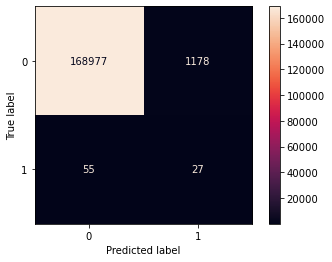

In [44]:
plot_confusion_matrix(cat_bayes, X_valid2, y_valid2, cmap='rocket', values_format='1')
plt.show()

### Model Insights - an improvement from our first model in terms of reducing false positives, but we also lost true positives and classified them as false negatives.

In [45]:
## optimize the model using a for loop and model type and a gridsearchCV
# BernoulliNB, CategoricalNB, GaussianNB, MultinomialNB

In [46]:
ran_for = RandomForestClassifier()
ada_clf = AdaBoostClassifier()
gb_clf = GradientBoostingClassifier()
gau_NB = GaussianNB()

models = [ran_for, ada_clf, gb_clf, gau_NB, cat_bayes]

In [47]:
def model_opt(models, x, y, xtest, ytest):
    for model in models:
        pipe = Pipeline(steps=[('model', model)])
        fit = pipe.fit(x, y)
        ypred = model.predict(xtest)
        print(model," ", fit.score(x, y))
        plot_confusion_matrix(model, xtest, ytest, cmap='rocket', values_format='1')
        plt.show()
        score_report(ytest, ypred)
    pass

RandomForestClassifier()   0.9999974824843851


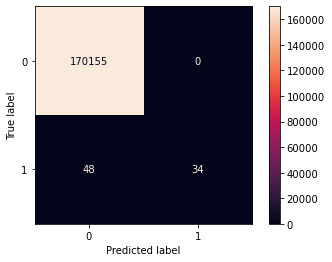

Accuracy Score:  0.9997180401440345
Precision Score:  1.0
Recall Score:  0.4146341463414634
F1 Score:  0.5862068965517241
AdaBoostClassifier()   0.9995216720331708


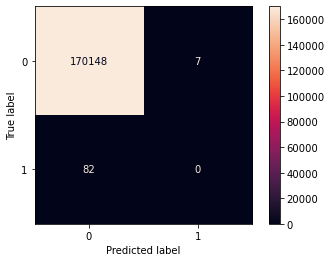

Accuracy Score:  0.9994771994337306
Precision Score:  0.0
Recall Score:  0.0
F1 Score:  0.0
GradientBoostingClassifier()   0.9994788742677176


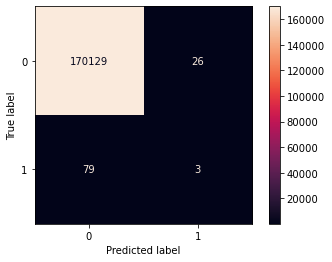

Accuracy Score:  0.9993832128150755
Precision Score:  0.10344827586206896
Recall Score:  0.036585365853658534
F1 Score:  0.05405405405405405
GaussianNB()   0.8368524005770146


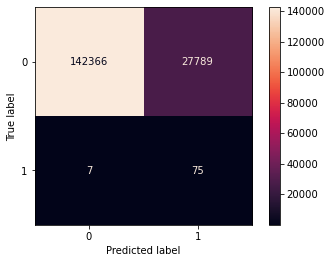

Accuracy Score:  0.8367217467413077
Precision Score:  0.002691645133505599
Recall Score:  0.9146341463414634
F1 Score:  0.005367494453589065
CategoricalNB()   0.9901993117112309


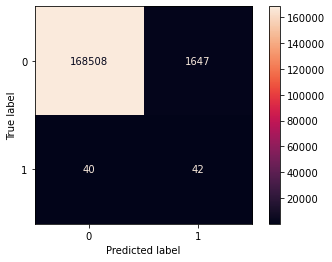

Accuracy Score:  0.9900902858955456
Precision Score:  0.02486678507992895
Recall Score:  0.5121951219512195
F1 Score:  0.047430830039525695


In [48]:
model_opt(models, X, y, X_valid, y_valid) # this is the full model dataset

### Out of the above models, Random Forest and Categorical Bayesian perform the best. Let's see if after applying feature selection if they continue to perform better than the other models. 

RandomForestClassifier()   0.9996198551421516


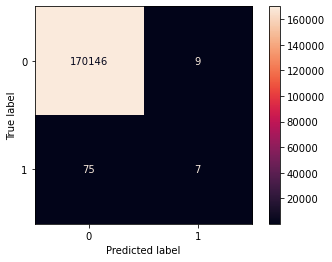

Accuracy Score:  0.9995065702520604
Precision Score:  0.4375
Recall Score:  0.08536585365853659
F1 Score:  0.14285714285714288
AdaBoostClassifier()   0.9995065669394815


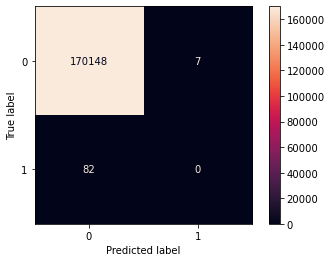

Accuracy Score:  0.9994771994337306
Precision Score:  0.0
Recall Score:  0.0
F1 Score:  0.0
GradientBoostingClassifier()   0.9994788742677176


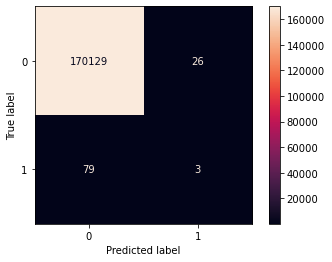

Accuracy Score:  0.9993832128150755
Precision Score:  0.10344827586206896
Recall Score:  0.036585365853658534
F1 Score:  0.05405405405405405
GaussianNB()   0.7723511330079025


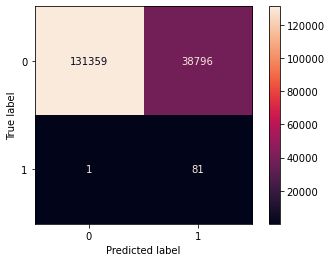

Accuracy Score:  0.7721000722522131
Precision Score:  0.0020834940967667257
Recall Score:  0.9878048780487805
F1 Score:  0.0041582176133884334
CategoricalNB()   0.9929887190125297


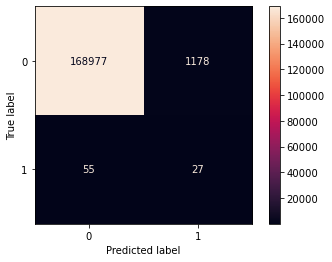

Accuracy Score:  0.992757156199886
Precision Score:  0.022406639004149378
Recall Score:  0.32926829268292684
F1 Score:  0.04195804195804196


In [49]:
model_opt(models, X2, y2, X_valid2, y_valid2) # this is the reduced feature set

# Random Forest performed significantly worse with a reduced set of features, while Categorical Bayes went sideways, reducing overall false positives from ~ 1650 to ~1150 but also losing true positives. 


### These are the top features that indicate any amount of deaths was likely during an accident in Chicago area crashes.

#### *EJECTION_TRAPPED/EXTRICATED (trapped within the vehicle requiring removal post-incident)
#### *PRIM_CONTRIBUTORY_CAUSE_PHYSICAL CONDITION OF DRIVER (intoxication)
#### *TRAFFICWAY_TYPE_Y-INTERSECTION (atypical traffic conditions)
#### *FIRST_CRASH_TYPE_PEDESTRIAN (a pedestrian is involved)
#### *CRASH_TYPE_INJURY AND / OR TOW DUE TO CRASH 
#### *AIRBAG_DEPLOYED_DEPLOYED, COMBINATION (higher speeds indicated)
#### *EJECTION_TOTALLY EJECTED (completed thrown from vehicle)
#### *SEC_CONTRIBUTORY_CAUSE_PHYSICAL CONDITION OF DRIVER (intoxication)

In [50]:
# GridsearchCV and improving the full set Random Forest classifier
# GridsearchCV and improving the partial set CategoricalNB classifier

### Tuning Hyper-parameters for a random forest model and a categorical bayes model

In [51]:
# create single item lists for input to model_opt and also gridsearchCV. 
selected_models = [ran_for, cat_bayes]

In [52]:
for model in selected_models:
    print(model.get_params().keys())

dict_keys(['bootstrap', 'ccp_alpha', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])
dict_keys(['alpha', 'class_prior', 'fit_prior'])


In [53]:
# pipe_random = Pipeline([
#     ('select', SelectKBest()),
#     ('model', ran_for)])
# pipe_bayes = Pipeline([
#     ('select', SelectKBest()),
#     ('model', cat_bayes)])

In [91]:
ran_for = RandomForestClassifier()
cat_bayes = CategoricalNB()
param_random = {
    "max_depth": [3,4,5],
    "n_estimators": [5,15,25],
    "max_leaf_nodes": range(3,10,2)
    }
param_bayes = {
    "alpha": [.05,.1,.2,.5,1,5,8,9,10,11,12,13,14],
    }

In [92]:
# need to improve on overall precision, so scoring for both models will be precision
gsforest = GridSearchCV(estimator=ran_for, param_grid=param_random, cv=5, scoring='precision', 
                    verbose=1, n_jobs=6)
gsbayes = GridSearchCV(cat_bayes, param_grid=param_bayes, cv=5, scoring='precision', 
                     verbose=1, n_jobs=6)

In [56]:
# initial dataset
gsforest.fit(X, y)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:  1.4min
[Parallel(n_jobs=6)]: Done 180 out of 180 | elapsed:  5.7min finished


GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=6,
             param_grid={'max_depth': [3, 4, 5],
                         'max_leaf_nodes': range(3, 10, 2),
                         'n_estimators': [5, 15, 25]},
             scoring='precision', verbose=1)

In [57]:
display(gsforest.best_estimator_)
display(gsforest.best_score_)

RandomForestClassifier(max_depth=3, max_leaf_nodes=3, n_estimators=5)

0.0

In [58]:
gsforest_f1 = gsforest.best_estimator_
gsforest_f1

RandomForestClassifier(max_depth=3, max_leaf_nodes=3, n_estimators=5)

In [59]:
print(gsforest_f1.score(X, y))
print(gsforest_f1.score(X_valid, y_valid))

0.9995342596112452
0.9995183185793922


In [60]:
gsforest_f1.fit(X, y)

RandomForestClassifier(max_depth=3, max_leaf_nodes=3, n_estimators=5)

In [61]:
y_preds = gsforest_f1.predict(X_valid)
sum(y_preds)

0

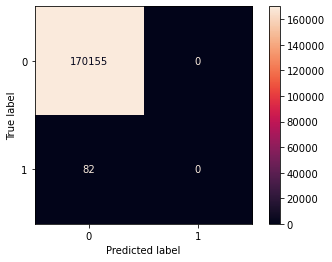

In [62]:
plot_confusion_matrix(gsforest_f1, X_valid, y_valid, cmap='rocket', values_format='1')
plt.show() # model is not predicting any fatalities at all

In [63]:
gsforest.fit(X2, y2)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:   21.8s
[Parallel(n_jobs=6)]: Done 180 out of 180 | elapsed:  1.7min finished


GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=6,
             param_grid={'max_depth': [3, 4, 5],
                         'max_leaf_nodes': range(3, 10, 2),
                         'n_estimators': [5, 15, 25]},
             scoring='precision', verbose=1)

In [64]:
gsforest_high_precision_partial = gsforest.best_estimator_
gsforest_high_precision_partial

RandomForestClassifier(max_depth=3, max_leaf_nodes=3, n_estimators=5)

In [65]:
gsforest_high_precision_partial.fit(X2, y2)

RandomForestClassifier(max_depth=3, max_leaf_nodes=3, n_estimators=5)

In [89]:
rcf_new = RandomForestClassifier(max_depth=3, max_leaf_nodes=3, n_estimators=5)
rcf_new.fit(X2, y2)
y_preds2 = rcf_new.predict(X_valid2)

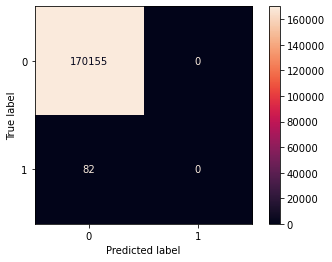

In [90]:
plot_confusion_matrix(rcf_new, X_valid2, y_valid2, cmap='rocket', values_format='1')
plt.show() # model is not predicting any fatalities at all - how do I make it so I dont predict so many zeros here?

In [95]:
cat_bayes = CategoricalNB(alpha=10)
cat_bayes.fit(X2, y2)


CategoricalNB(alpha=10)

In [96]:
y_valid2_preds = cat_bayes.predict(X_valid2)

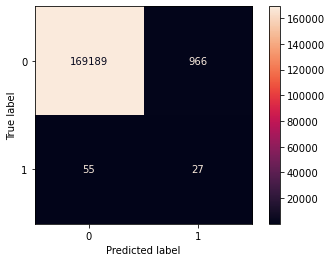

In [98]:
plot_confusion_matrix(cat_bayes, X_valid2, y_valid2, cmap='rocket', values_format='1')
plt.show() # decently pleased with this model, but I want to do better as well as count feature
# occurrence in accidents with fatalities

In [ ]:
print(gsforest_high_precision.score(X, y)) # full feature set
print(gsforest_high_precision_partial.score(X2, y2)) # top 18 feature set
print(gsbayes_high_precision_partial.score(X2, y2)) # top 18 feature set

In [ ]:
# going to plot and analyze forest_partial_best confusion matrix
# as well as gsbayes_partial confusion matrix

In [ ]:
# predict on gsforest_high_precision full set 
forest_y_preds = gsforest_high_precision.predict(X_valid)
# define forest_partial model y predict 
forest_partial_y_preds = gsforest_high_precision_partial.predict(X_valid2)
# define bayes_partial model y predict
bayes_partial_y_preds = gsbayes_high_precision_partial.predict(X_valid2)
final_models = [forest_y_preds, forest_partial_y_preds, bayes_partial_y_preds]

In [ ]:
def plot_confusion(ytrue, ypred):
    cm_norm = confusion_matrix(ytrue, ypred, normalize='true')
    sns.heatmap(cm_norm, cmap=sns.color_palette('Blues'), fmt='{:.2f}', annot=True, annot_kws={"va":"bottom"})
    cm = confusion_matrix(ytrue, ypred)
    sns.heatmap(cm, cmap=sns.color_palette('Blues'), fmt='{:.2f}', annot=True, annot_kws={"va":"top"})
    plt.show()

In [ ]:
def model_scoring(models, )
for model in models:
    train_score = model.score(x_train_resampled, y_train_resampled)
    test_score = model.score(x_test, y_test)
    avg_score = (train_score + test_score)/2
    print(model ,train_score, test_score, avg_score)

In [ ]:
def evaluate_test_data(logreg, df_test, feature_for_modeling, target='y'):
    df_test = transform_dataframe(df_test)
    X = df_test[feature_for_modeling]
    y = df_test[target]
    score = logreg.score(X, y)
    print(f"Score of model = {score}")
    y_pred = logreg.predict(X)
    plot_confusion(y, y_pred)
    pass

evaluate_test_data(cat_bayes,df_test=df_valid, feature_for_modeling=feature_list)

In [ ]:
def cost_benefit_analysis(model, X_test, y_test):
    y_preds = model.predict(X_test)
    label_dict = {"TP":0, "FP": 0, "TN": 0, "FN": 0}
    for yt, yp in zip(y_test, y_preds):
        if yt==yp:
            if yt==1:
                label_dict["TP"] += 1
            else:
                label_dict["TN"] += 1
        else:
            if yp==1:
                label_dict["FP"] += 1
            else:
                label_dict["FN"] += 1
    cb_dict = {"TP": 50, "FP": -10, "TN": 0, "FN": -60}
    total = 0
    for key in label_dict.keys():
        total += cb_dict[key]*label_dict[key]
    return total / sum(label_dict.values())